In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load dataset paths
dataset_path = '/kaggle/input/face-mask-detection/'  # Kaggle stores the data in this path
annotations_path = os.path.join(dataset_path, 'annotations')
images_path = os.path.join(dataset_path, 'images')

# Preview available image files
image_files = os.listdir(images_path)
print(f"Total images: {len(image_files)}")


Total images: 853


In [2]:
# Data Preprocessing
from xml.etree import ElementTree as ET

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    label = None
    for member in root.findall('object'):
        label = member.find('name').text
        break  # Use the first label if multiple objects exist
    return label

images = []
labels = []

for image_file in image_files:
    # Load image
    image_path = os.path.join(images_path, image_file)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))  # Resize to 128x128
    img = img / 255.0  # Normalize

    # Parse corresponding XML annotation
    xml_file = image_file.replace('.png', '.xml')
    xml_path = os.path.join(annotations_path, xml_file)
    label = parse_annotation(xml_path)

    # Convert label to binary (1 for mask, 0 for no mask)
    if label == "mask":
        labels.append(1)
    else:
        labels.append(0)

    images.append(img)

X = np.array(images)
y = np.array(labels)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training data size: {len(X_train)}, Validation data size: {len(X_val)}")


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


Training data size: 682, Validation data size: 171


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Training the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 545ms/step - accuracy: 0.8831 - loss: 0.1178 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 550ms/step - accuracy: 1.0000 - loss: 8.6060e-31 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 518ms/step - accuracy: 1.0000 - loss: 5.2904e-27 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 521ms/step - accuracy: 1.0000 - loss: 9.1014e-33 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 546ms/step - accuracy: 1.0000 - loss: 4.3963e-34 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 518ms/step - accuracy: 1.0000 - loss: 3.2989e-30 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 524ms/step - accuracy: 1.0000 - loss: 1.0591e-28 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 550

In [5]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Validation Accuracy: 100.00%


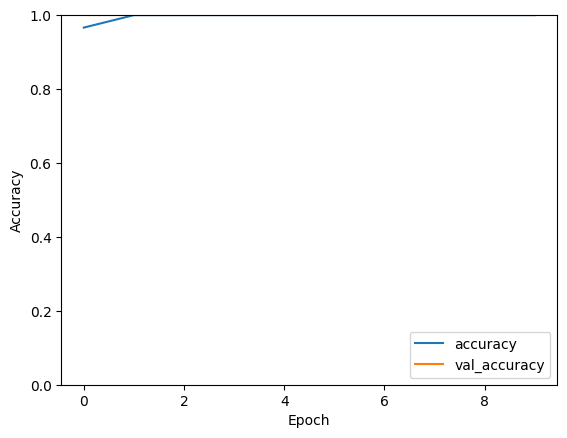

In [6]:
# Visualize results
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [7]:
# # test the model results with images
# import cv2
# import numpy as np

# # Function to preprocess and predict mask
# def predict_mask(image_path):
#     img = cv2.imread(image_path)
#     img = cv2.resize(img, (128, 128))  # Resize to the same size used in training
#     img = img / 255.0  # Normalize
#     img = np.expand_dims(img, axis=0)  # Add batch dimension
    
#     prediction = model.predict(img)
#     if prediction[0][0] > 0.5:
#         print(f"No Mask Detected in {image_path}")
#     else:
#         print(f"Mask Detected in {image_path}")

# # Test with your images
# # Example: Replace with your uploaded file paths
# predict_mask('/kaggle/input/your-uploaded-dataset/mask_image.jpg')
# predict_mask('/kaggle/input/your-uploaded-dataset/no_mask_image.jpg')



In [8]:
# Test on Kaggle Dataset
test_image = X_val[0]  # This is one image from validation data



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Mask Detected


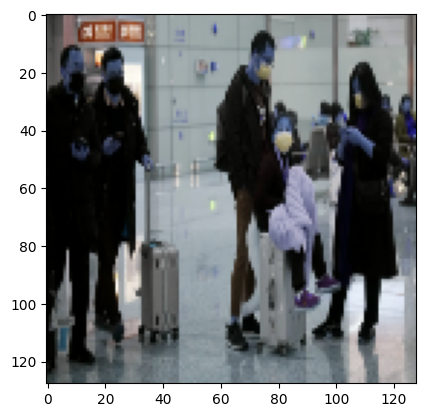

In [9]:
import matplotlib.pyplot as plt

def predict_image(img):
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    if prediction[0][0] > 0.5:
        return "No Mask Detected"
    else:
        return "Mask Detected"

# Display the image
plt.imshow(X_val[169])

# Predict and print the result
print(predict_image(X_val[170]))
